In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import tensorboardX as tx
from datetime import datetime

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

# Modified Second Scenario

Let's Modify the second scenario in the tutorial. We will introduce many more cost functions and then after that a cost function which gives noisy data and after that compare performance of different exploration algorithms using visualization.

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        


def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE        
        
# SECOND MODIFIED SCENARIO 

def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE    
        
def get_cost_new4(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'camping':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE        
        
def get_cost_new5(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'finance':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
        
                

## Let's make reward function to produce Noise now

Designing a suitable reward function plays a critical role in building reinforcement learning models for real-world applications. Ideally, one would want to customize reward functions to achieve application-specific goals. In practice, however, it is difficult to design a reward function that produces credible rewards in the presence of noise. This is because the **output from any reward function is subject to multiple kinds of randomness in the presence of noise**.
But as we are simulating so we make a cost function (reward function) which gives us output that is subject to randomness so in this way we will be able to add noise to reward distribution. This is one of the simplest ways in case of our simulation.

In [4]:
def get_cost_noise(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    
    #Strip the last newline
    return example_string[:-1]

In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
#     print(total, scale)
    pmf = [x * scale for x in pmf]
#     print(pmf)
    draw = random.random()
    sum_prob = 0.0
    
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [7]:
# Convert the context and actions into the text format needed.
# Pass this example to Vowpal Wabbit and get the PMF output.
# Sample this PMF to get the article to show.
# Return the chosen article and the probability of choosing it. 
# Note: We need the probability when we learn from this example.

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    
    pmf = vw.predict(vw_text_example)
    
    chosen_action_index, prob = sample_custom_pmf(pmf)
    
    return actions[chosen_action_index], prob

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [9]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

In [10]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn=True, tensorboard=False):
    if tensorboard:
        logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")  # logs directory
        file_writer = tx.SummaryWriter(logdir + "/ctr")   # creating file writer
#         file_writer.set_as_default()    
    
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
            
            if tensorboard:
                file_writer.add_scalar('ctr', (-1*cost_sum/i), i)   #  scalar value of ctr in this iteration
            
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    
    if tensorboard:
        file_writer.close()   # close file writer
    
    return ctr

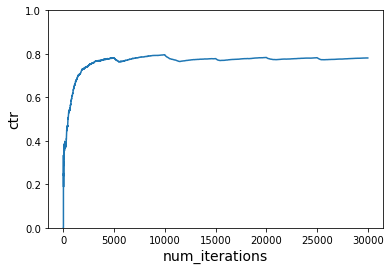

In [11]:
# With learning
# use first reward function initially and then switch to other reward functions

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1, get_cost_new2, get_cost_new3, get_cost_new4, get_cost_new5]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

## Let's Now Use Reward Function which adds Noise to Reward Distribution

We would now change the cost function with respect to time which produces noise and add noise to our reward distribution (CTR). We can experiment with different ways to change cost functions with time but let's try simple one

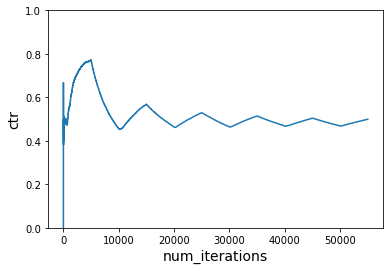

In [12]:
# With learning
# use first reward function initially and then switch to noise and other reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise, get_cost_new1, get_cost_noise, get_cost_new2, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_epsilon = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, tensorboard=True)

plot_ctr(total_iterations, ctr_epsilon)

## Experimentation with Different Exploration Algorithms

Let's try using different exploration strategies and then visualize the performances. We would use:
Explore-First Strategy
Bagging
Softmax
RND   all as per the documentation

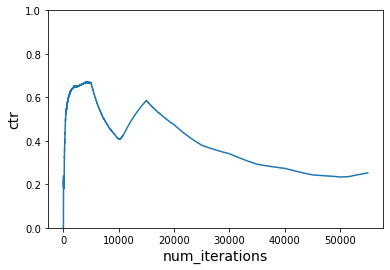

In [13]:
# use first reward function initially and then switch to noise and other reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 7")  # Explore-first

# num_iterations_per_cost_func = 5000
# cost_functions = [get_cost, get_cost_noise, get_cost_new1, get_cost_noise, get_cost_new2, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5]
# total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_first = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, tensorboard=True)

plot_ctr(total_iterations, ctr_first)

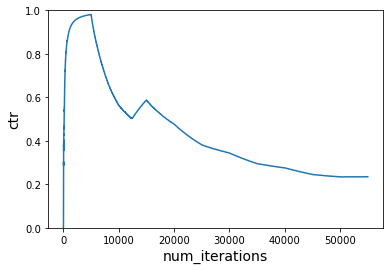

In [14]:
# use first reward function initially and then switch to noise and other reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 7")

# num_iterations_per_cost_func = 5000
# cost_functions = [get_cost, get_cost_noise, get_cost_new1, get_cost_noise, get_cost_new2, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5]
# total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_bag = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, tensorboard=True)

plot_ctr(total_iterations, ctr_bag)

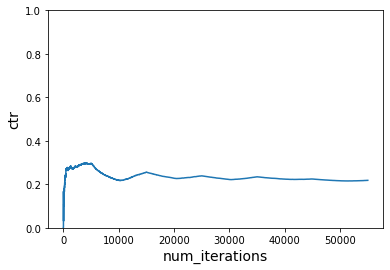

In [15]:
# use first reward function initially and then switch to noise and other reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax lambda 7")

# num_iterations_per_cost_func = 5000
# cost_functions = [get_cost, get_cost_noise, get_cost_new1, get_cost_noise, get_cost_new2, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5]
# total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_soft = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, tensorboard=True)

plot_ctr(total_iterations, ctr_soft)

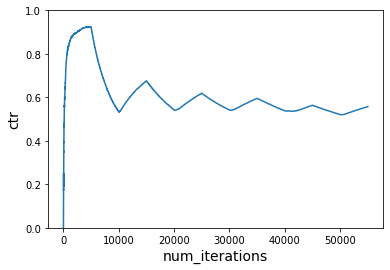

In [16]:
# use first reward function initially and then switch to noise and other reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.02")

# num_iterations_per_cost_func = 5000
# cost_functions = [get_cost, get_cost_noise, get_cost_new1, get_cost_noise, get_cost_new2, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5]
# total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr_rnd = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, tensorboard=True)

plot_ctr(total_iterations, ctr_rnd)

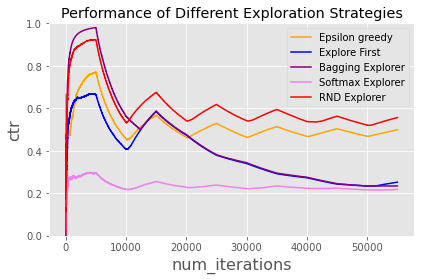

In [17]:
num_of_iterations = range(1, total_iterations+1)
font_size = 16

plt.style.use('ggplot')
plt.plot(num_of_iterations, ctr_epsilon, label='Epsilon greedy', color='orange')
plt.plot(num_of_iterations, ctr_first, label='Explore First', color='blue')
plt.plot(num_of_iterations, ctr_bag, label='Bagging Explorer', color='purple')
plt.plot(num_of_iterations, ctr_soft, label='Softmax Explorer', color='violet')
plt.plot(num_of_iterations, ctr_rnd, label='RND Explorer', color='red')

plt.xlabel('num_iterations', fontsize=font_size)
plt.ylabel('ctr', fontsize=font_size)
plt.title('Performance of Different Exploration Strategies')
plt.ylim([0,1])
plt.legend()
plt.tight_layout()

# Conclusion
We have used different exploration algorithms here and each algorithm performs differently in so many ways than other algorithms. RND Exploration is most like better performer than Epsilon greedy but it can be tuned further which could give us great results even in the presence of noise as many Reinforcement Learning algorithms perform poor due to noisy data. Explore First and Bagging after a peak or so start declining in performance which shows that due to noise they were unable to learn effectively. Softmax Explorer on the other hand looked like an algorithm that didn't learn, maybe it can be improved by finding out the better hyperparameters. 